In [1]:
import pm4py
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

c:\Users\Martin\Desktop\Quarter 2\Advanced Process Mining\Project\process-mining-project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- 1. CONFIGURATION ---
LOG_FILE = "./BPI_Challenge_2017.xes"
DECISION_POINT = "A_Complete"

In [3]:
# --- 2. DATA LOADING ---
log = pm4py.read_xes(LOG_FILE)
df = pm4py.convert_to_dataframe(log)

c:\Users\Martin\Desktop\Quarter 2\Advanced Process Mining\Project\process-mining-project\.venv\lib\site-packages\pm4py\utils.py:992: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")
c:\Users\Martin\Desktop\Quarter 2\Advanced Process Mining\Project\process-mining-project\.venv\lib\site-packages\pm4py\util\dt_parsing\parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
parsing log, completed traces :: 100%|██████████| 31509/31509 [00:44<00:00, 706.43it/s]


In [4]:
# Sort by Case and Time to ensure sequential order
if 'time:timestamp' in df.columns:
    df = df.sort_values(by=['case:concept:name', 'time:timestamp'])

In [5]:
# Identify useful data columns dynamically
cols = df.columns.tolist()
# 'CreditScore' is often a key driver for cancellations
score_col = next((c for c in cols if 'CreditScore' in c or 'score' in c.lower()), None)
# 'MonthlyCost' or 'LoanGoal' are also useful
# amount_col = next((c for c in cols if 'RequestedAmount' in c or 'Amount' in c), None)
terms_col = next((c for c in cols if 'Terms' in c or 'term' in c.lower()), None)

print(f"Using Data Columns: {score_col}, {terms_col}")

Using Data Columns: CreditScore, NumberOfTerms


In [ ]:
# --- 3. FEATURE ENGINEERING (Prefix Extraction) ---
# We group by case and "cut" the trace at 'A_Complete'
case_groups = df.groupby("case:concept:name")

data_rows = []
labels = []
case_ids = []

unique_activities = df["concept:name"].unique()
act_to_int = {act: i for i, act in enumerate(unique_activities)}

print("Extracting Features...")
for case_id, group in tqdm(case_groups):
    events = group["concept:name"].tolist()
    timestamps = group["time:timestamp"].tolist()
    
    # FILTER: Only consider cases that actually reached 'A_Complete'
    if DECISION_POINT not in events:
        continue
        
    # SPLIT: Cut the trace exactly at the decision point
    # We pretend we don't see anything after this point
    split_idx = events.index(DECISION_POINT)
    
    # The 'Visible' trace (History)
    visible_events = events[:split_idx+1]
    
    # The 'Future' trace (Target)
    future_events = events[split_idx+1:]
    
    ### CHANGE in labelling
    # if "O_Refused" in future_events:
    #     label = 2
    if "A_Cancelled" in future_events:
        label = 1
    elif "A_Pending" in future_events:
        label = 0
    else:
        # Here, this includes both O_Refused and the remaining 130 traces
        continue

    # --- BUILD FEATURE VECTOR ---
    feature_vector = []

    # 0. Terms
    current_amount = 0.0
    # if amount_col:
    #     visible_values = group.iloc[:split_idx+1][amount_col]
    if terms_col:
        visible_values = group.iloc[:split_idx+1][terms_col]
        valid_values = visible_values.dropna()
        if not valid_values.empty:
            current_amount = float(valid_values.iloc[-1])
    feature_vector.append(current_amount)

    # 1. Domain Data: Credit Score (Last known value before decision)
    current_credit = 0
    if score_col:
        # Get values up to decision point
        visible_values = group.iloc[:split_idx+1][score_col]
        valid_values = visible_values.dropna()
        if not valid_values.empty:
            current_credit = valid_values.iloc[-1]
    feature_vector.append(current_credit)

    # 2. Offer count
    offer_count = visible_events.count("O_Create Offer")
    feature_vector.append(float(offer_count))

    # 3. Process Metric: Duration (Time since case start)
    start_time = timestamps[0]
    decision_time = timestamps[split_idx]
    duration_days = (decision_time - start_time).total_seconds() / 86400.0
    feature_vector.append(duration_days)
    
    # 4. Process Metric: Workload/Counts (Bag of Words)
    # How many times did each activity happen so far?
    bow_vector = [0] * len(unique_activities)
    for act in visible_events:
        bow_vector[act_to_int[act]] += 1
    feature_vector.extend(bow_vector)
    
    # 5. Process Metric: Last Activity (One-Hot)
    # The last event before the decision is often critical
    last_act_vector = [0] * len(unique_activities)
    if visible_events:
        last_act = visible_events[-1]
        last_act_vector[act_to_int[last_act]] = 1
    feature_vector.extend(last_act_vector)
    
    data_rows.append(feature_vector)
    labels.append(label)
    case_ids.append(case_id)

X = np.array(data_rows)
y = np.array(labels)

print(f"Dataset Ready. Total Samples: {len(X)}")

Extracting Features...


100%|██████████| 31509/31509 [00:11<00:00, 2782.59it/s]


Dataset Ready. Total Samples: 27549


In [7]:
# --- 4. PREPARATION FOR PYTORCH ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

# 1. Split Train/Test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Scale features (Critical for Neural Networks)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# 3. Convert to PyTorch Tensors
# INPUTS: Must be Float32
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

# TARGETS: Must be Long (Integers) for CrossEntropyLoss
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t = torch.tensor(y_test, dtype=torch.long)

print(f"Train Size: {len(X_train)} | Test Size: {len(X_test)}")

# --- 5. MODEL DEFINITION (Multi-Class) ---
class MultiClassPredictor(nn.Module):
    def __init__(self, input_dim):
        super(MultiClassPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 2) 
        )
        
    def forward(self, x):
        return self.network(x)

model = MultiClassPredictor(input_dim=X.shape[1])

# CHANGE: Use sklearn to compute balanced weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weights = torch.tensor(class_weights, dtype=torch.float32)
print(f"Class Weights: {weights}")

criterion = nn.CrossEntropyLoss(weight=weights)
# CHANGE: Use AdamW and Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# --- 6. TRAINING ---
print("Training Neural Network...")
dataset = TensorDataset(X_train_t, y_train_t)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

model.train()
epochs = 100
loss_history = []

for epoch in range(epochs): 
    epoch_loss = 0
    model.train()
    for xb, yb in loader:
        optimizer.zero_grad()
        y_pred = model(xb)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(loader)
    loss_history.append(avg_loss)
    
    # Validation for Scheduler
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_test_t)
        val_loss = criterion(y_val_pred, y_test_t)
    
    scheduler.step(val_loss)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss.item():.4f}")

Train Size: 22039 | Test Size: 5510
Class Weights: tensor([0.7969, 1.3420])
Training Neural Network...
Epoch 5/100, Train Loss: 0.3339, Val Loss: 0.3324
Epoch 10/100, Train Loss: 0.3331, Val Loss: 0.3324
Epoch 15/100, Train Loss: 0.3316, Val Loss: 0.3307
Epoch 20/100, Train Loss: 0.3311, Val Loss: 0.3322
Epoch 25/100, Train Loss: 0.3304, Val Loss: 0.3313
Epoch 30/100, Train Loss: 0.3275, Val Loss: 0.3317
Epoch 35/100, Train Loss: 0.3296, Val Loss: 0.3325
Epoch 40/100, Train Loss: 0.3302, Val Loss: 0.3327
Epoch 45/100, Train Loss: 0.3283, Val Loss: 0.3323
Epoch 50/100, Train Loss: 0.3307, Val Loss: 0.3322
Epoch 55/100, Train Loss: 0.3293, Val Loss: 0.3321
Epoch 60/100, Train Loss: 0.3270, Val Loss: 0.3321
Epoch 65/100, Train Loss: 0.3287, Val Loss: 0.3325
Epoch 70/100, Train Loss: 0.3276, Val Loss: 0.3321
Epoch 75/100, Train Loss: 0.3282, Val Loss: 0.3321
Epoch 80/100, Train Loss: 0.3292, Val Loss: 0.3319
Epoch 85/100, Train Loss: 0.3265, Val Loss: 0.3326
Epoch 90/100, Train Loss: 0.329


=== CLASSIFICATION REPORT ===
               precision    recall  f1-score   support

  Pending (0)       0.96      0.74      0.84      3400
Cancelled (1)       0.70      0.95      0.81      2110

     accuracy                           0.82      5510
    macro avg       0.83      0.85      0.82      5510
 weighted avg       0.86      0.82      0.83      5510



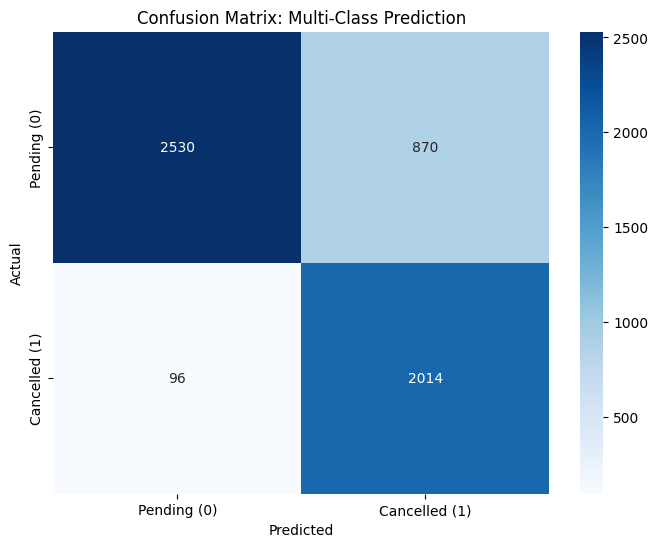

In [9]:
# --- 7. EVALUATION ---
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_t)
    # Get the class index with the highest score
    y_pred_classes = torch.argmax(y_pred_logits, dim=1).numpy()

print("\n=== CLASSIFICATION REPORT ===")
target_names = ['Pending (0)', 'Cancelled (1)']
print(classification_report(y_test, y_pred_classes, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Multi-Class Prediction")
plt.show()